In [1]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import optimizers


In [2]:
def kalman_filter(z_meas, x_esti, P):
    """Kalman Filter Algorithm for One Variable."""
    # (1) Prediction.
    x_pred = A * x_esti
    P_pred = A * P * A + Q

    # (2) Kalman Gain.
    K = P_pred * H / (H * P_pred * H + R)

    # (3) Estimation.
    x_esti = x_pred + K * (z_meas - H * x_pred)

    # (4) Error Covariance.
    P = P_pred - K * H * P_pred

    return x_esti, P

In [3]:

# Initialization for system model.
A = 1
H = 1
Q = 0.1
R = 7
# Initialization for estimation.
x_0 = 10  # 14 for book.
P_0 = 6

In [4]:
forecasting = 20

In [5]:
df = pd.read_csv('trainset/J0003_0024_0222_20110307012737_cell_1.csv', encoding='utf8')
df

,MeasuredDate,CellNo,Resistance,Volt,Temp
0,2011.3.7 6:27,1,0.259,2.23,-20
1,2011.3.7 18:29,1,0.260,2.23,-20
2,2011.3.8 6:29,1,0.259,2.23,-20
3,2011.3.8 18:29,1,0.259,2.23,-20
4,2011.3.9 6:29,1,0.259,2.23,-20
...,...,...,...,...,...
254,2011.8.30 5:28,1,0.301,2.23,-20
255,2011.8.30 17:28,1,0.301,2.23,-20
256,2011.8.31 5:28,1,0.302,2.23,-20
257,2011.8.31 16:09,1,0.300,2.23,-20


In [6]:
df = df['Resistance']
df

0      0.259
1      0.260
2      0.259
3      0.259
4      0.259
       ...  
254    0.301
255    0.301
256    0.302
257    0.300
258    0.296
Name: Resistance, Length: 259, dtype: float64

<AxesSubplot:>

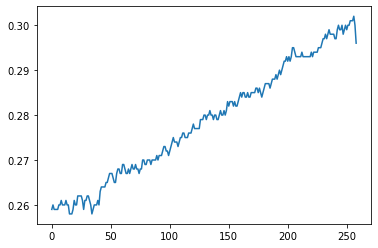

In [7]:
df.plot()

In [8]:
n_samples = len(df)
x_0 = df[1]
r_meas_save = np.zeros(n_samples)
r_esti_save = np.zeros(n_samples)

x_esti, P = None, None
for i in range(n_samples):
    r_meas = df[i]
    if i == 0:
        x_esti, P = x_0, P_0
    else:
        x_esti, P = kalman_filter(r_meas, x_esti, P)
        # print(x_esti[1])
    r_meas_save[i] = r_meas
    r_esti_save[i] = x_esti

#print("123", x_esti)

df = r_esti_save

In [9]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scale_cols = ['Resistance']
df = pd.DataFrame(df)
df.columns = scale_cols
df_scaled = scaler.fit_transform(df[scale_cols])

df_scaled = pd.DataFrame(df_scaled)
df_scaled.columns = scale_cols

print(type(df_scaled))

<class 'pandas.core.frame.DataFrame'>


In [10]:
train = df_scaled

In [11]:
def make_dataset(data, label, window_size=forecasting):
    feature_list = []
    label_list = []
    for i in range(len(data) - window_size):
        feature_list.append(np.array(data.iloc[i:i+window_size]))
        label_list.append(np.array(label.iloc[i+window_size]))
    return np.array(feature_list), np.array(label_list)

In [12]:
feature_cols = ['Resistance']
label_cols = ['Resistance']

train_feature = train[feature_cols]
train_label = train[label_cols]
# test_feature = test[feature_cols]
# test_label = test[label_cols]

train_feature, train_label = make_dataset(train_feature, train_label, forecasting)
total_len = len(train_feature)

x_train = train_feature[:int(total_len*0.8)]
x_valid = train_feature[int(total_len*0.8):]
y_train = train_label[:int(total_len*0.8)]
y_valid = train_label[int(total_len*0.8):]

In [33]:
x_train.shape

(191, 20, 1)

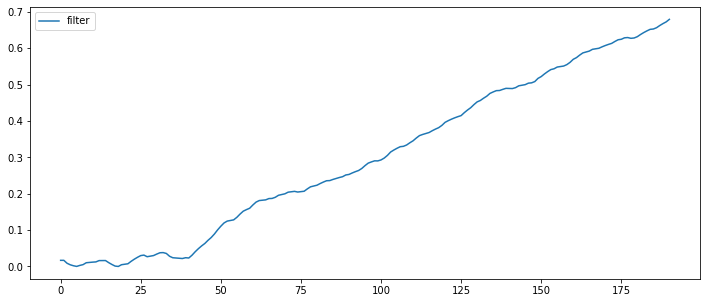

In [14]:
plt.figure(figsize=(12,5))
plt.plot(x_train[:,0,0],label="filter")
# plt.ylim(0,1)
plt.legend()
plt.show()

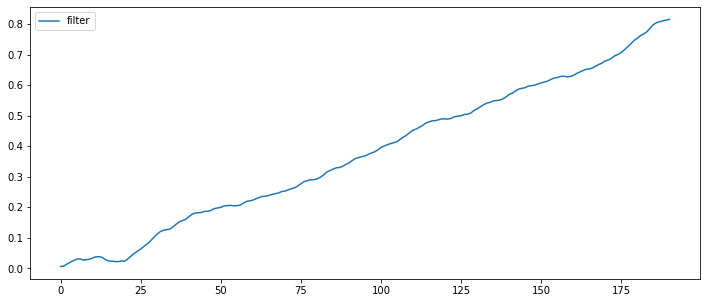

In [20]:
y_train.shape
plt.figure(figsize=(12,5))
plt.plot(y_train[:,0],label="filter")
# plt.ylim(0,1)
plt.legend()
plt.show()

In [21]:
OUT_STEPS = 20

In [22]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(30, 
               input_shape=(train_feature.shape[1], train_feature.shape[2]), 
               activation='relu', 
               return_sequences=False)
          )
model.add(tf.keras.layers.Dense(OUT_STEPS*1))
model.add(tf.keras.layers.Reshape([OUT_STEPS, 1]))

In [34]:
model.compile(loss=tf.losses.MeanSquaredError(), optimizer=tf.optimizers.Adam(lr=0.001), metrics=[tf.metrics.MeanAbsoluteError()])
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
filename = os.path.join('models/', 'kjgreftmp_checkpoint.h5')
checkpoint = tf.keras.callbacks.ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

h = model.fit(x_train, x_train, 
                    epochs=1000, 
                    batch_size=16)

Epoch 1/1000
12/12 [==============================] - 2s 5ms/step - loss: 0.0016 - mean_absolute_error: 0.0310
Epoch 2/1000
12/12 [==============================] - 0s 5ms/step - loss: 4.8891e-04 - mean_absolute_error: 0.0165
Epoch 3/1000
12/12 [==============================] - 0s 5ms/step - loss: 3.1504e-04 - mean_absolute_error: 0.0131
Epoch 4/1000
12/12 [==============================] - 0s 5ms/step - loss: 2.4293e-04 - mean_absolute_error: 0.0115
Epoch 5/1000
12/12 [==============================] - 0s 8ms/step - loss: 2.2395e-04 - mean_absolute_error: 0.0110
Epoch 6/1000
12/12 [==============================] - 0s 4ms/step - loss: 1.9764e-04 - mean_absolute_error: 0.0109
Epoch 7/1000
12/12 [==============================] - 0s 5ms/step - loss: 2.1670e-04 - mean_absolute_error: 0.0111
Epoch 8/1000
12/12 [==============================] - 0s 5ms/step - loss: 1.8425e-04 - mean_absolute_error: 0.0102
Epoch 9/1000
12/12 [==============================] - 0s 5ms/step - loss: 1.6940e-04

12/12 [==============================] - 0s 4ms/step - loss: 6.6202e-05 - mean_absolute_error: 0.0064
Epoch 72/1000
12/12 [==============================] - 0s 5ms/step - loss: 6.0030e-05 - mean_absolute_error: 0.0060
Epoch 73/1000
12/12 [==============================] - 0s 6ms/step - loss: 6.6499e-05 - mean_absolute_error: 0.0062
Epoch 74/1000
12/12 [==============================] - 0s 5ms/step - loss: 6.6958e-05 - mean_absolute_error: 0.0063
Epoch 75/1000
12/12 [==============================] - 0s 4ms/step - loss: 6.1085e-05 - mean_absolute_error: 0.0060
Epoch 76/1000
12/12 [==============================] - 0s 5ms/step - loss: 6.1049e-05 - mean_absolute_error: 0.0059
Epoch 77/1000
12/12 [==============================] - 0s 6ms/step - loss: 5.5675e-05 - mean_absolute_error: 0.0057
Epoch 78/1000
12/12 [==============================] - 0s 6ms/step - loss: 6.6458e-05 - mean_absolute_error: 0.0062
Epoch 79/1000
12/12 [==============================] - 0s 6ms/step - loss: 6.6962e-05 

12/12 [==============================] - 0s 5ms/step - loss: 4.4344e-05 - mean_absolute_error: 0.0050
Epoch 142/1000
12/12 [==============================] - 0s 5ms/step - loss: 4.5876e-05 - mean_absolute_error: 0.0051
Epoch 143/1000
12/12 [==============================] - 0s 5ms/step - loss: 4.9403e-05 - mean_absolute_error: 0.0054
Epoch 144/1000
12/12 [==============================] - 0s 5ms/step - loss: 4.3912e-05 - mean_absolute_error: 0.0051
Epoch 145/1000
12/12 [==============================] - 0s 4ms/step - loss: 5.1228e-05 - mean_absolute_error: 0.0055
Epoch 146/1000
12/12 [==============================] - 0s 5ms/step - loss: 4.4389e-05 - mean_absolute_error: 0.0051
Epoch 147/1000
12/12 [==============================] - 0s 5ms/step - loss: 6.3997e-05 - mean_absolute_error: 0.0061
Epoch 148/1000
12/12 [==============================] - 0s 5ms/step - loss: 5.1447e-05 - mean_absolute_error: 0.0056
Epoch 149/1000
12/12 [==============================] - 0s 5ms/step - loss: 6.8

12/12 [==============================] - 0s 5ms/step - loss: 5.6686e-05 - mean_absolute_error: 0.0058
Epoch 212/1000
12/12 [==============================] - 0s 5ms/step - loss: 4.7917e-05 - mean_absolute_error: 0.0053
Epoch 213/1000
12/12 [==============================] - 0s 6ms/step - loss: 4.5349e-05 - mean_absolute_error: 0.0052
Epoch 214/1000
12/12 [==============================] - 0s 5ms/step - loss: 3.8784e-05 - mean_absolute_error: 0.0047
Epoch 215/1000
12/12 [==============================] - 0s 5ms/step - loss: 4.5198e-05 - mean_absolute_error: 0.0053
Epoch 216/1000
12/12 [==============================] - 0s 6ms/step - loss: 4.6352e-05 - mean_absolute_error: 0.0054
Epoch 217/1000
12/12 [==============================] - 0s 6ms/step - loss: 3.3863e-05 - mean_absolute_error: 0.0045
Epoch 218/1000
12/12 [==============================] - 0s 6ms/step - loss: 3.7949e-05 - mean_absolute_error: 0.0048
Epoch 219/1000
12/12 [==============================] - 0s 6ms/step - loss: 3.8

12/12 [==============================] - 0s 5ms/step - loss: 4.7850e-05 - mean_absolute_error: 0.0053
Epoch 281/1000
12/12 [==============================] - 0s 5ms/step - loss: 5.0473e-05 - mean_absolute_error: 0.0055
Epoch 282/1000
12/12 [==============================] - 0s 5ms/step - loss: 5.4591e-05 - mean_absolute_error: 0.0058
Epoch 283/1000
12/12 [==============================] - 0s 5ms/step - loss: 5.0053e-05 - mean_absolute_error: 0.0055
Epoch 284/1000
12/12 [==============================] - 0s 4ms/step - loss: 4.5219e-05 - mean_absolute_error: 0.0052
Epoch 285/1000
12/12 [==============================] - 0s 5ms/step - loss: 3.1191e-05 - mean_absolute_error: 0.0043
Epoch 286/1000
12/12 [==============================] - 0s 6ms/step - loss: 2.6899e-05 - mean_absolute_error: 0.0040
Epoch 287/1000
12/12 [==============================] - 0s 5ms/step - loss: 3.0655e-05 - mean_absolute_error: 0.0043
Epoch 288/1000
12/12 [==============================] - 0s 5ms/step - loss: 2.9

12/12 [==============================] - 0s 4ms/step - loss: 2.9139e-05 - mean_absolute_error: 0.0043
Epoch 351/1000
12/12 [==============================] - 0s 4ms/step - loss: 2.4175e-05 - mean_absolute_error: 0.0039
Epoch 352/1000
12/12 [==============================] - 0s 4ms/step - loss: 2.7674e-05 - mean_absolute_error: 0.0041
Epoch 353/1000
12/12 [==============================] - 0s 4ms/step - loss: 2.7064e-05 - mean_absolute_error: 0.0040
Epoch 354/1000
12/12 [==============================] - 0s 5ms/step - loss: 2.5608e-05 - mean_absolute_error: 0.0039
Epoch 355/1000
12/12 [==============================] - 0s 5ms/step - loss: 2.6845e-05 - mean_absolute_error: 0.0040
Epoch 356/1000
12/12 [==============================] - 0s 4ms/step - loss: 2.5088e-05 - mean_absolute_error: 0.0039
Epoch 357/1000
12/12 [==============================] - 0s 4ms/step - loss: 2.3372e-05 - mean_absolute_error: 0.0037
Epoch 358/1000
12/12 [==============================] - 0s 5ms/step - loss: 2.5

12/12 [==============================] - 0s 5ms/step - loss: 4.5019e-05 - mean_absolute_error: 0.0052
Epoch 420/1000
12/12 [==============================] - 0s 5ms/step - loss: 3.0388e-05 - mean_absolute_error: 0.0042
Epoch 421/1000
12/12 [==============================] - 0s 4ms/step - loss: 2.3446e-05 - mean_absolute_error: 0.0038
Epoch 422/1000
12/12 [==============================] - 0s 4ms/step - loss: 2.7815e-05 - mean_absolute_error: 0.0041
Epoch 423/1000
12/12 [==============================] - 0s 6ms/step - loss: 2.3403e-05 - mean_absolute_error: 0.0038
Epoch 424/1000
12/12 [==============================] - 0s 5ms/step - loss: 2.1820e-05 - mean_absolute_error: 0.0036
Epoch 425/1000
12/12 [==============================] - 0s 4ms/step - loss: 2.4748e-05 - mean_absolute_error: 0.0039
Epoch 426/1000
12/12 [==============================] - 0s 5ms/step - loss: 4.1959e-05 - mean_absolute_error: 0.0051
Epoch 427/1000
12/12 [==============================] - 0s 6ms/step - loss: 3.7

12/12 [==============================] - 0s 5ms/step - loss: 2.7308e-05 - mean_absolute_error: 0.0041
Epoch 490/1000
12/12 [==============================] - 0s 5ms/step - loss: 2.3915e-05 - mean_absolute_error: 0.0038
Epoch 491/1000
12/12 [==============================] - 0s 6ms/step - loss: 2.5108e-05 - mean_absolute_error: 0.0039
Epoch 492/1000
12/12 [==============================] - 0s 5ms/step - loss: 2.3851e-05 - mean_absolute_error: 0.0038
Epoch 493/1000
12/12 [==============================] - 0s 5ms/step - loss: 2.4204e-05 - mean_absolute_error: 0.0039
Epoch 494/1000
12/12 [==============================] - 0s 6ms/step - loss: 2.5499e-05 - mean_absolute_error: 0.0039
Epoch 495/1000
12/12 [==============================] - 0s 5ms/step - loss: 3.3714e-05 - mean_absolute_error: 0.0046
Epoch 496/1000
12/12 [==============================] - 0s 5ms/step - loss: 2.7820e-05 - mean_absolute_error: 0.0040
Epoch 497/1000
12/12 [==============================] - 0s 5ms/step - loss: 2.5

12/12 [==============================] - 0s 5ms/step - loss: 1.8695e-05 - mean_absolute_error: 0.0034
Epoch 559/1000
12/12 [==============================] - 0s 5ms/step - loss: 2.3678e-05 - mean_absolute_error: 0.0038
Epoch 560/1000
12/12 [==============================] - 0s 5ms/step - loss: 2.4966e-05 - mean_absolute_error: 0.0039
Epoch 561/1000
12/12 [==============================] - 0s 4ms/step - loss: 2.1674e-05 - mean_absolute_error: 0.0036
Epoch 562/1000
12/12 [==============================] - 0s 4ms/step - loss: 1.9736e-05 - mean_absolute_error: 0.0034
Epoch 563/1000
12/12 [==============================] - 0s 5ms/step - loss: 2.1017e-05 - mean_absolute_error: 0.0035
Epoch 564/1000
12/12 [==============================] - 0s 4ms/step - loss: 2.0409e-05 - mean_absolute_error: 0.0035
Epoch 565/1000
12/12 [==============================] - 0s 4ms/step - loss: 1.8421e-05 - mean_absolute_error: 0.0034
Epoch 566/1000
12/12 [==============================] - 0s 4ms/step - loss: 1.9

12/12 [==============================] - 0s 4ms/step - loss: 1.7903e-05 - mean_absolute_error: 0.0033
Epoch 629/1000
12/12 [==============================] - 0s 5ms/step - loss: 1.8666e-05 - mean_absolute_error: 0.0034
Epoch 630/1000
12/12 [==============================] - 0s 5ms/step - loss: 1.8717e-05 - mean_absolute_error: 0.0033
Epoch 631/1000
12/12 [==============================] - 0s 6ms/step - loss: 1.8813e-05 - mean_absolute_error: 0.0034
Epoch 632/1000
12/12 [==============================] - 0s 5ms/step - loss: 1.5991e-05 - mean_absolute_error: 0.0031
Epoch 633/1000
12/12 [==============================] - 0s 4ms/step - loss: 1.8377e-05 - mean_absolute_error: 0.0033
Epoch 634/1000
12/12 [==============================] - 0s 5ms/step - loss: 2.0899e-05 - mean_absolute_error: 0.0036
Epoch 635/1000
12/12 [==============================] - 0s 5ms/step - loss: 2.0271e-05 - mean_absolute_error: 0.0035
Epoch 636/1000
12/12 [==============================] - 0s 6ms/step - loss: 2.0

12/12 [==============================] - 0s 4ms/step - loss: 1.8126e-05 - mean_absolute_error: 0.0033
Epoch 699/1000
12/12 [==============================] - 0s 5ms/step - loss: 1.9449e-05 - mean_absolute_error: 0.0035
Epoch 700/1000
12/12 [==============================] - 0s 4ms/step - loss: 1.7972e-05 - mean_absolute_error: 0.0034
Epoch 701/1000
12/12 [==============================] - 0s 5ms/step - loss: 1.5477e-05 - mean_absolute_error: 0.0031
Epoch 702/1000
12/12 [==============================] - 0s 4ms/step - loss: 1.6428e-05 - mean_absolute_error: 0.0031
Epoch 703/1000
12/12 [==============================] - 0s 5ms/step - loss: 1.9265e-05 - mean_absolute_error: 0.0034
Epoch 704/1000
12/12 [==============================] - 0s 4ms/step - loss: 1.8174e-05 - mean_absolute_error: 0.0033
Epoch 705/1000
12/12 [==============================] - 0s 4ms/step - loss: 2.3747e-05 - mean_absolute_error: 0.0038
Epoch 706/1000
12/12 [==============================] - 0s 4ms/step - loss: 1.6

12/12 [==============================] - 0s 6ms/step - loss: 1.5958e-05 - mean_absolute_error: 0.0031
Epoch 769/1000
12/12 [==============================] - 0s 8ms/step - loss: 1.5414e-05 - mean_absolute_error: 0.0030
Epoch 770/1000
12/12 [==============================] - 0s 9ms/step - loss: 1.7566e-05 - mean_absolute_error: 0.0032
Epoch 771/1000
12/12 [==============================] - 0s 7ms/step - loss: 1.6287e-05 - mean_absolute_error: 0.0031
Epoch 772/1000
12/12 [==============================] - 0s 5ms/step - loss: 1.6789e-05 - mean_absolute_error: 0.0032
Epoch 773/1000
12/12 [==============================] - 0s 6ms/step - loss: 2.1488e-05 - mean_absolute_error: 0.0036
Epoch 774/1000
12/12 [==============================] - 0s 5ms/step - loss: 2.4899e-05 - mean_absolute_error: 0.0039
Epoch 775/1000
12/12 [==============================] - 0s 5ms/step - loss: 1.8473e-05 - mean_absolute_error: 0.0033
Epoch 776/1000
12/12 [==============================] - 0s 6ms/step - loss: 1.6

12/12 [==============================] - 0s 6ms/step - loss: 1.6351e-05 - mean_absolute_error: 0.0031
Epoch 839/1000
12/12 [==============================] - 0s 5ms/step - loss: 2.0265e-05 - mean_absolute_error: 0.0035
Epoch 840/1000
12/12 [==============================] - 0s 5ms/step - loss: 1.5387e-05 - mean_absolute_error: 0.0030
Epoch 841/1000
12/12 [==============================] - 0s 5ms/step - loss: 1.7907e-05 - mean_absolute_error: 0.0033
Epoch 842/1000
12/12 [==============================] - 0s 5ms/step - loss: 2.0862e-05 - mean_absolute_error: 0.0036
Epoch 843/1000
12/12 [==============================] - 0s 5ms/step - loss: 1.8797e-05 - mean_absolute_error: 0.0033
Epoch 844/1000
12/12 [==============================] - 0s 5ms/step - loss: 1.8282e-05 - mean_absolute_error: 0.0034
Epoch 845/1000
12/12 [==============================] - 0s 5ms/step - loss: 2.0116e-05 - mean_absolute_error: 0.0035
Epoch 846/1000
12/12 [==============================] - 0s 5ms/step - loss: 1.6

12/12 [==============================] - 0s 5ms/step - loss: 1.7493e-05 - mean_absolute_error: 0.0033
Epoch 909/1000
12/12 [==============================] - 0s 5ms/step - loss: 1.7023e-05 - mean_absolute_error: 0.0032
Epoch 910/1000
12/12 [==============================] - 0s 4ms/step - loss: 1.7077e-05 - mean_absolute_error: 0.0032
Epoch 911/1000
12/12 [==============================] - 0s 6ms/step - loss: 2.2575e-05 - mean_absolute_error: 0.0036
Epoch 912/1000
12/12 [==============================] - 0s 6ms/step - loss: 2.2699e-05 - mean_absolute_error: 0.0036
Epoch 913/1000
12/12 [==============================] - 0s 6ms/step - loss: 1.6686e-05 - mean_absolute_error: 0.0032
Epoch 914/1000
12/12 [==============================] - 0s 4ms/step - loss: 1.5209e-05 - mean_absolute_error: 0.0030
Epoch 915/1000
12/12 [==============================] - 0s 5ms/step - loss: 1.5720e-05 - mean_absolute_error: 0.0031
Epoch 916/1000
12/12 [==============================] - 0s 6ms/step - loss: 1.7

12/12 [==============================] - 0s 6ms/step - loss: 1.4035e-05 - mean_absolute_error: 0.0029
Epoch 978/1000
12/12 [==============================] - 0s 6ms/step - loss: 2.1558e-05 - mean_absolute_error: 0.0036
Epoch 979/1000
12/12 [==============================] - 0s 5ms/step - loss: 1.7208e-05 - mean_absolute_error: 0.0032
Epoch 980/1000
12/12 [==============================] - 0s 5ms/step - loss: 1.9212e-05 - mean_absolute_error: 0.0033
Epoch 981/1000
12/12 [==============================] - 0s 5ms/step - loss: 2.1172e-05 - mean_absolute_error: 0.0036
Epoch 982/1000
12/12 [==============================] - 0s 7ms/step - loss: 1.7165e-05 - mean_absolute_error: 0.0032
Epoch 983/1000
12/12 [==============================] - 0s 6ms/step - loss: 1.4721e-05 - mean_absolute_error: 0.0030
Epoch 984/1000
12/12 [==============================] - 0s 5ms/step - loss: 1.5471e-05 - mean_absolute_error: 0.0031
Epoch 985/1000
12/12 [==============================] - 0s 5ms/step - loss: 1.3

In [35]:
test_df = pd.read_csv('testset/J0003_0024_0221_20110307012732_cell_23.csv', encoding='utf8')

In [36]:
test_df

,MeasuredDate,CellNo,Resistance,Volt,Temp
0,2011.3.7 6:27,23,0.333,2.24,-20
1,2011.3.7 18:29,23,0.333,2.24,-20
2,2011.3.8 6:29,23,0.332,2.24,-20
3,2011.3.8 18:29,23,0.333,2.24,-20
4,2011.3.9 6:29,23,0.333,2.24,-20
...,...,...,...,...,...
246,2011.8.29 17:28,23,0.524,2.27,-20
247,2011.8.30 5:28,23,0.524,2.27,-20
248,2011.8.30 17:28,23,0.528,2.27,-20
249,2011.8.31 5:28,23,0.528,2.27,-20


In [37]:
x_test2 = test_df['Resistance']

In [38]:
n_samples = len(x_test2)
x_0 = x_test2[1]

r_meas_save = np.zeros(n_samples)
r_esti_save = np.zeros(n_samples)

x_esti, P = None, None
for i in range(n_samples):
    r_meas = x_test2[i]
    if i == 0:
        x_esti, P = x_0, P_0
    else:
        x_esti, P = kalman_filter(r_meas, x_esti, P)
        # print(x_esti[1])
    r_meas_save[i] = r_meas
    r_esti_save[i] = x_esti

#print("123", x_esti)

x_test2 = r_esti_save

In [39]:
x_test2 = pd.DataFrame(x_test2)
x_test2.columns = scale_cols
x_test2 = scaler.fit_transform(x_test2)
x_test2 = pd.DataFrame(x_test2)
y_test2 = x_test2

In [40]:
train_feature2, train_label2 = make_dataset(x_test2, y_test2, forecasting)

In [41]:
pred2 = model.predict(train_feature2)

In [42]:
len(train_feature2)

231

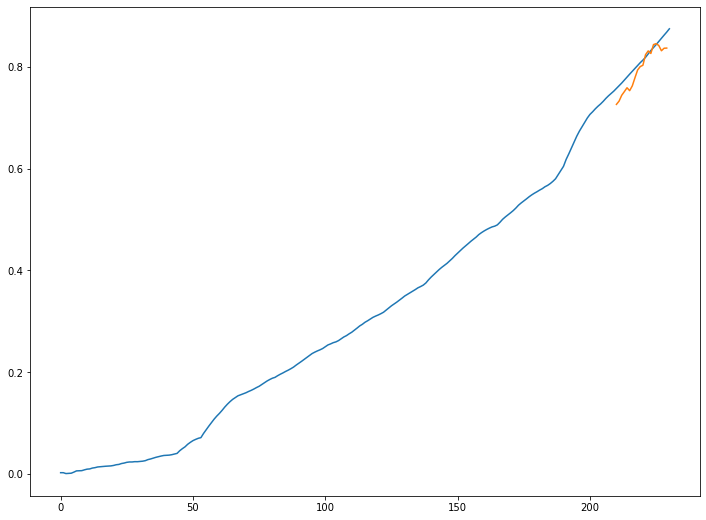

In [43]:
x_data = range(230)
plt.figure(figsize=(12, 9))
plt.plot(train_feature2[:, 0,0], label ='actual')

predictions = model(train_feature2)
plt.plot(x_data[210:], predictions[210,:,0], label='predictions')

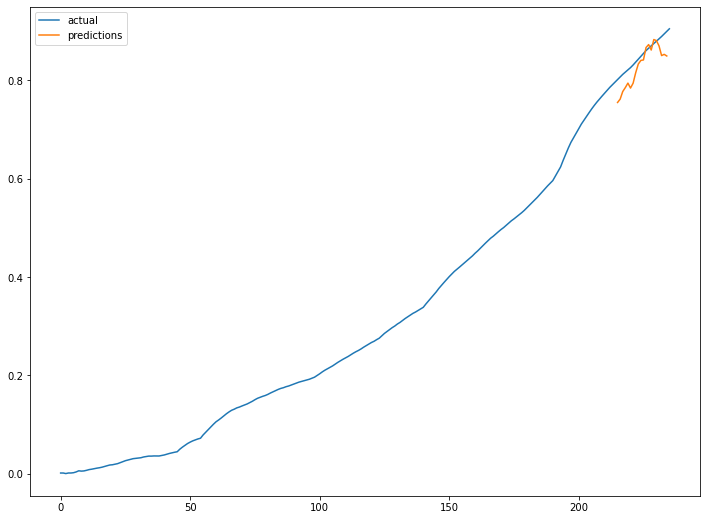

In [44]:
test_df = pd.read_csv('testset/J0003_0024_0221_20110307012732_cell_06.csv', encoding='utf8')

x_test2 = test_df['Resistance']

n_samples = len(x_test2)
x_0 = x_test2[1]

r_meas_save = np.zeros(n_samples)
r_esti_save = np.zeros(n_samples)

x_esti, P = None, None
for i in range(n_samples):
    r_meas = x_test2[i]
    if i == 0:
        x_esti, P = x_0, P_0
    else:
        x_esti, P = kalman_filter(r_meas, x_esti, P)
        # print(x_esti[1])
    r_meas_save[i] = r_meas
    r_esti_save[i] = x_esti

#print("123", x_esti)

x_test2 = r_esti_save

x_test2 = pd.DataFrame(x_test2)
x_test2.columns = scale_cols
x_test2 = scaler.fit_transform(x_test2)
x_test2 = pd.DataFrame(x_test2)
y_test2 = x_test2

train_feature2, train_label2 = make_dataset(x_test2, y_test2, forecasting)

predictions = model.predict(train_feature2)

feature_len = len(train_feature2) - 1
plot_len = feature_len-OUT_STEPS

x_data = range(feature_len)
plt.figure(figsize=(12, 9))
plt.plot(train_feature2[:, 0,0], label ='actual')
plt.plot(x_data[plot_len:], predictions[plot_len,:,0], label='predictions')
plt.legend()

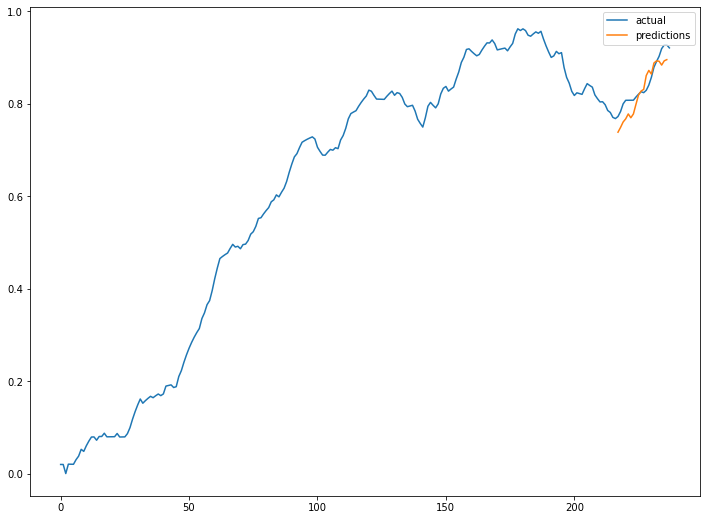

In [45]:
test_df = pd.read_csv('testset/J0003_0024_0221_20110307012732_cell_03.csv', encoding='utf8')

x_test2 = test_df['Resistance']

n_samples = len(x_test2)
x_0 = x_test2[1]

r_meas_save = np.zeros(n_samples)
r_esti_save = np.zeros(n_samples)

x_esti, P = None, None
for i in range(n_samples):
    r_meas = x_test2[i]
    if i == 0:
        x_esti, P = x_0, P_0
    else:
        x_esti, P = kalman_filter(r_meas, x_esti, P)
        # print(x_esti[1])
    r_meas_save[i] = r_meas
    r_esti_save[i] = x_esti

#print("123", x_esti)

x_test2 = r_esti_save

x_test2 = pd.DataFrame(x_test2)
x_test2.columns = scale_cols
x_test2 = scaler.fit_transform(x_test2)
x_test2 = pd.DataFrame(x_test2)
y_test2 = x_test2

train_feature2, train_label2 = make_dataset(x_test2, y_test2, forecasting)

predictions = model.predict(train_feature2)

feature_len = len(train_feature2) - 1
plot_len = feature_len-OUT_STEPS

x_data = range(feature_len)
plt.figure(figsize=(12, 9))
plt.plot(train_feature2[:, 0,0], label ='actual')
plt.plot(x_data[plot_len:], predictions[plot_len,:,0], label='predictions')
plt.legend()

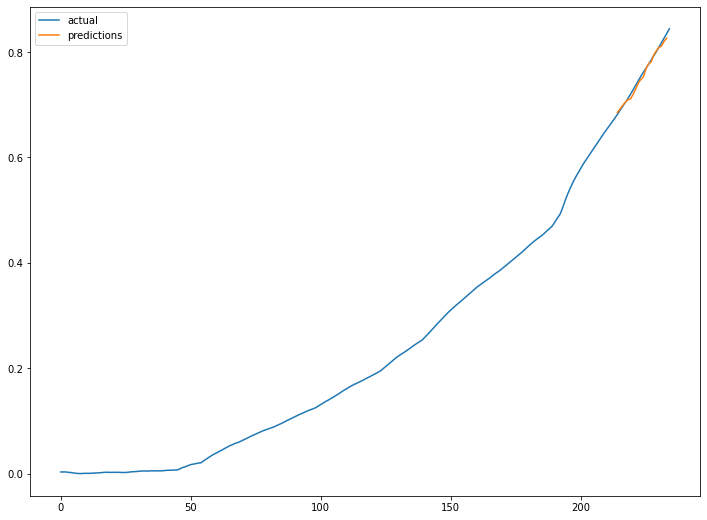

In [46]:
test_df = pd.read_csv('testset/J0003_0024_0221_20110307012732_cell_7.csv', encoding='utf8')

x_test2 = test_df['Resistance']

n_samples = len(x_test2)
x_0 = x_test2[1]

r_meas_save = np.zeros(n_samples)
r_esti_save = np.zeros(n_samples)

x_esti, P = None, None
for i in range(n_samples):
    r_meas = x_test2[i]
    if i == 0:
        x_esti, P = x_0, P_0
    else:
        x_esti, P = kalman_filter(r_meas, x_esti, P)
        # print(x_esti[1])
    r_meas_save[i] = r_meas
    r_esti_save[i] = x_esti

#print("123", x_esti)

x_test2 = r_esti_save

x_test2 = pd.DataFrame(x_test2)
x_test2.columns = scale_cols
x_test2 = scaler.fit_transform(x_test2)
x_test2 = pd.DataFrame(x_test2)
y_test2 = x_test2

train_feature2, train_label2 = make_dataset(x_test2, y_test2, forecasting)

predictions = model.predict(train_feature2)

feature_len = len(train_feature2) - 1
plot_len = feature_len-OUT_STEPS

x_data = range(feature_len)
plt.figure(figsize=(12, 9))
plt.plot(train_feature2[:, 0,0], label ='actual')
plt.plot(x_data[plot_len:], predictions[plot_len,:,0], label='predictions')
plt.legend()

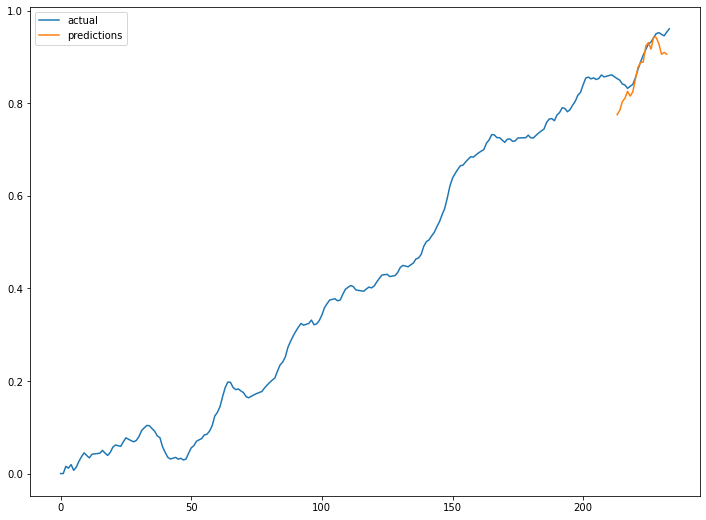

In [47]:
test_df = pd.read_csv('testset/J0003_0024_0221_20110307012732_cell_9.csv', encoding='utf8')

x_test2 = test_df['Resistance']

n_samples = len(x_test2)
x_0 = x_test2[1]

r_meas_save = np.zeros(n_samples)
r_esti_save = np.zeros(n_samples)

x_esti, P = None, None
for i in range(n_samples):
    r_meas = x_test2[i]
    if i == 0:
        x_esti, P = x_0, P_0
    else:
        x_esti, P = kalman_filter(r_meas, x_esti, P)
        # print(x_esti[1])
    r_meas_save[i] = r_meas
    r_esti_save[i] = x_esti

#print("123", x_esti)

x_test2 = r_esti_save

x_test2 = pd.DataFrame(x_test2)
x_test2.columns = scale_cols
x_test2 = scaler.fit_transform(x_test2)
x_test2 = pd.DataFrame(x_test2)
y_test2 = x_test2

train_feature2, train_label2 = make_dataset(x_test2, y_test2, forecasting)

predictions = model.predict(train_feature2)

feature_len = len(train_feature2) - 1
plot_len = feature_len-OUT_STEPS

x_data = range(feature_len)
plt.figure(figsize=(12, 9))
plt.plot(train_feature2[:, 0,0], label ='actual')
plt.plot(x_data[plot_len:], predictions[plot_len,:,0], label='predictions')
plt.legend()

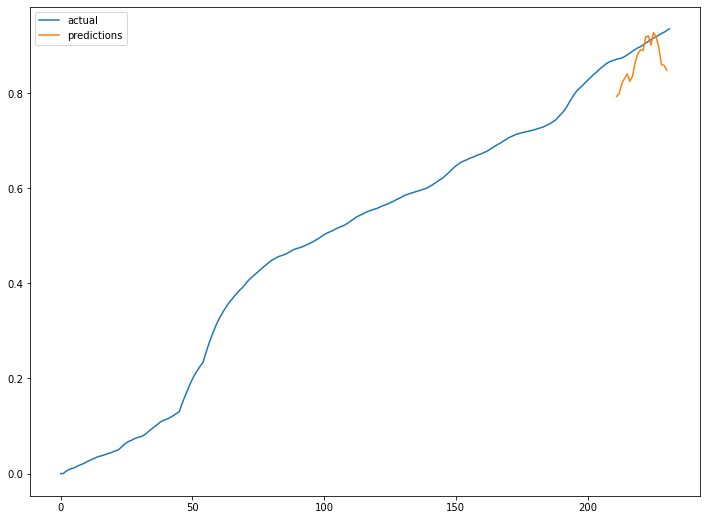

In [48]:
test_df = pd.read_csv('testset/J0003_0024_0221_20110307012732_cell_18.csv', encoding='utf8')

x_test2 = test_df['Resistance']

n_samples = len(x_test2)
x_0 = x_test2[1]

r_meas_save = np.zeros(n_samples)
r_esti_save = np.zeros(n_samples)

x_esti, P = None, None
for i in range(n_samples):
    r_meas = x_test2[i]
    if i == 0:
        x_esti, P = x_0, P_0
    else:
        x_esti, P = kalman_filter(r_meas, x_esti, P)
        # print(x_esti[1])
    r_meas_save[i] = r_meas
    r_esti_save[i] = x_esti

#print("123", x_esti)

x_test2 = r_esti_save

x_test2 = pd.DataFrame(x_test2)
x_test2.columns = scale_cols
x_test2 = scaler.fit_transform(x_test2)
x_test2 = pd.DataFrame(x_test2)
y_test2 = x_test2

train_feature2, train_label2 = make_dataset(x_test2, y_test2, forecasting)

predictions = model.predict(train_feature2)

feature_len = len(train_feature2) - 1
plot_len = feature_len-OUT_STEPS

x_data = range(feature_len)
plt.figure(figsize=(12, 9))
plt.plot(train_feature2[:, 0,0], label ='actual')
plt.plot(x_data[plot_len:], predictions[plot_len,:,0], label='predictions')
plt.legend()

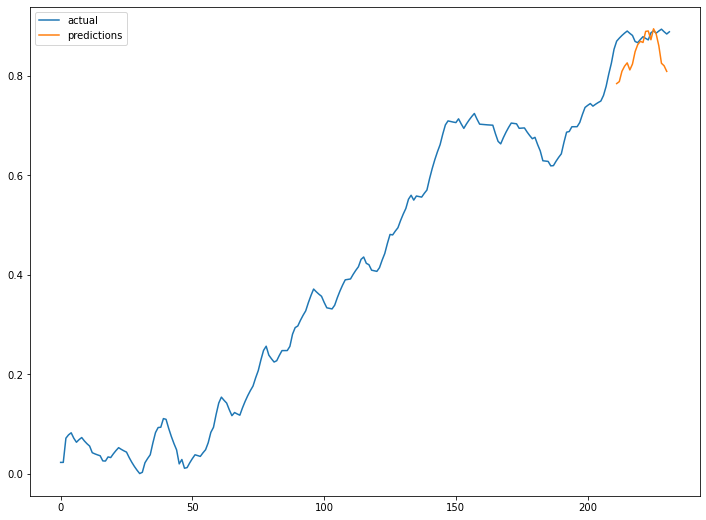

In [49]:
test_df = pd.read_csv('testset/J0003_0024_0221_20110307012732_cell_19.csv', encoding='utf8')

x_test2 = test_df['Resistance']

n_samples = len(x_test2)
x_0 = x_test2[1]

r_meas_save = np.zeros(n_samples)
r_esti_save = np.zeros(n_samples)

x_esti, P = None, None
for i in range(n_samples):
    r_meas = x_test2[i]
    if i == 0:
        x_esti, P = x_0, P_0
    else:
        x_esti, P = kalman_filter(r_meas, x_esti, P)
        # print(x_esti[1])
    r_meas_save[i] = r_meas
    r_esti_save[i] = x_esti

#print("123", x_esti)

x_test2 = r_esti_save

x_test2 = pd.DataFrame(x_test2)
x_test2.columns = scale_cols
x_test2 = scaler.fit_transform(x_test2)
x_test2 = pd.DataFrame(x_test2)
y_test2 = x_test2

train_feature2, train_label2 = make_dataset(x_test2, y_test2, forecasting)

predictions = model.predict(train_feature2)

feature_len = len(train_feature2) - 1
plot_len = feature_len-OUT_STEPS

x_data = range(feature_len)
plt.figure(figsize=(12, 9))
plt.plot(train_feature2[:, 0,0], label ='actual')
plt.plot(x_data[plot_len:], predictions[plot_len,:,0], label='predictions')
plt.legend()

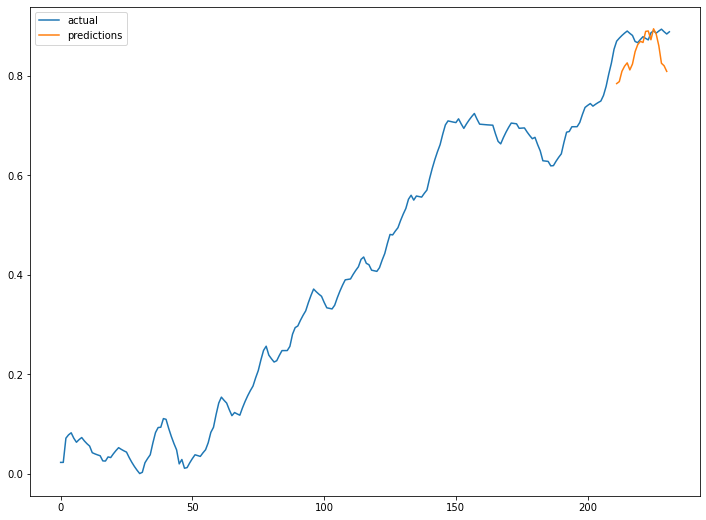

In [50]:
test_df = pd.read_csv('testset/J0003_0024_0221_20110307012732_cell_19.csv', encoding='utf8')

x_test2 = test_df['Resistance']

n_samples = len(x_test2)
x_0 = x_test2[1]

r_meas_save = np.zeros(n_samples)
r_esti_save = np.zeros(n_samples)

x_esti, P = None, None
for i in range(n_samples):
    r_meas = x_test2[i]
    if i == 0:
        x_esti, P = x_0, P_0
    else:
        x_esti, P = kalman_filter(r_meas, x_esti, P)
        # print(x_esti[1])
    r_meas_save[i] = r_meas
    r_esti_save[i] = x_esti

#print("123", x_esti)

x_test2 = r_esti_save

x_test2 = pd.DataFrame(x_test2)
x_test2.columns = scale_cols
x_test2 = scaler.fit_transform(x_test2)
x_test2 = pd.DataFrame(x_test2)
y_test2 = x_test2

train_feature2, train_label2 = make_dataset(x_test2, y_test2, forecasting)

predictions = model.predict(train_feature2)

feature_len = len(train_feature2) - 1
plot_len = feature_len-OUT_STEPS

x_data = range(feature_len)
plt.figure(figsize=(12, 9))
plt.plot(train_feature2[:, 0,0], label ='actual')
plt.plot(x_data[plot_len:], predictions[plot_len,:,0], label='predictions')
plt.legend()

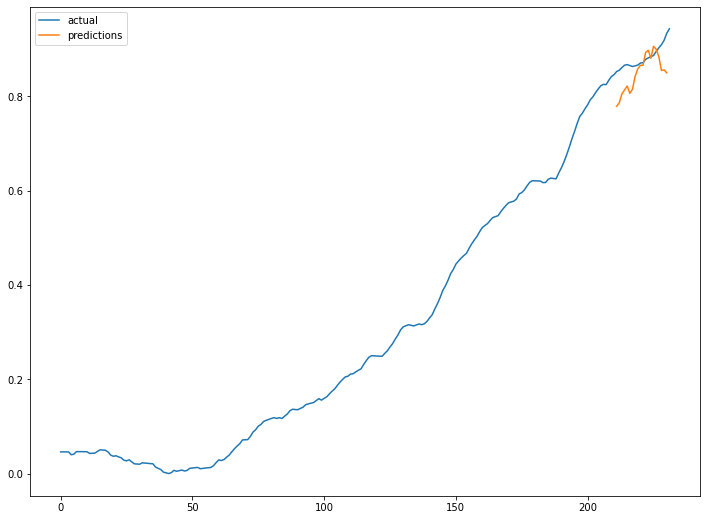

In [51]:
test_df = pd.read_csv('testset/J0003_0024_0221_20110307012732_cell_20.csv', encoding='utf8')

x_test2 = test_df['Resistance']

n_samples = len(x_test2)
x_0 = x_test2[1]

r_meas_save = np.zeros(n_samples)
r_esti_save = np.zeros(n_samples)

x_esti, P = None, None
for i in range(n_samples):
    r_meas = x_test2[i]
    if i == 0:
        x_esti, P = x_0, P_0
    else:
        x_esti, P = kalman_filter(r_meas, x_esti, P)
        # print(x_esti[1])
    r_meas_save[i] = r_meas
    r_esti_save[i] = x_esti

#print("123", x_esti)

x_test2 = r_esti_save

x_test2 = pd.DataFrame(x_test2)
x_test2.columns = scale_cols
x_test2 = scaler.fit_transform(x_test2)
x_test2 = pd.DataFrame(x_test2)
y_test2 = x_test2

train_feature2, train_label2 = make_dataset(x_test2, y_test2, forecasting)

predictions = model.predict(train_feature2)

feature_len = len(train_feature2) - 1
plot_len = feature_len-OUT_STEPS

x_data = range(feature_len)
plt.figure(figsize=(12, 9))
plt.plot(train_feature2[:, 0,0], label ='actual')
plt.plot(x_data[plot_len:], predictions[plot_len,:,0], label='predictions')
plt.legend()

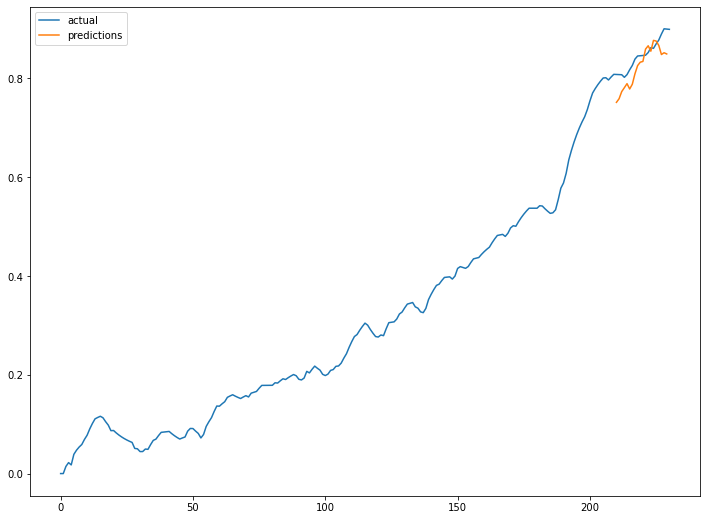

In [52]:
test_df = pd.read_csv('testset/J0003_0024_0221_20110307012732_cell_22.csv', encoding='utf8')

x_test2 = test_df['Resistance']

n_samples = len(x_test2)
x_0 = x_test2[1]

r_meas_save = np.zeros(n_samples)
r_esti_save = np.zeros(n_samples)

x_esti, P = None, None
for i in range(n_samples):
    r_meas = x_test2[i]
    if i == 0:
        x_esti, P = x_0, P_0
    else:
        x_esti, P = kalman_filter(r_meas, x_esti, P)
        # print(x_esti[1])
    r_meas_save[i] = r_meas
    r_esti_save[i] = x_esti

#print("123", x_esti)

x_test2 = r_esti_save

x_test2 = pd.DataFrame(x_test2)
x_test2.columns = scale_cols
x_test2 = scaler.fit_transform(x_test2)
x_test2 = pd.DataFrame(x_test2)
y_test2 = x_test2

train_feature2, train_label2 = make_dataset(x_test2, y_test2, forecasting)

predictions = model.predict(train_feature2)

feature_len = len(train_feature2) - 1
plot_len = feature_len-OUT_STEPS

x_data = range(feature_len)
plt.figure(figsize=(12, 9))
plt.plot(train_feature2[:, 0,0], label ='actual')
plt.plot(x_data[plot_len:], predictions[plot_len,:,0], label='predictions')
plt.legend()